In [2]:
# hide
%load_ext autoreload
%autoreload 2
%load_ext nb_black
%load_ext lab_black

<IPython.core.display.Javascript object>

In [3]:
# default_exp evaluation

<IPython.core.display.Javascript object>

# Evaluation
> Compute evaluation metrics.

## Overview

This section provides evaluation schemes for both Numerai Classic and Signals.
The `Evaluator` takes a `NumerFrame` as input and returns a Pandas DataFrame containing metrics for each given prediction column.

In [4]:
# export
import time
import json
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from typing import Tuple, Union
from numerapi import SignalsAPI

from numerblox.numerframe import NumerFrame, create_numerframe
from numerblox.postprocessing import FeatureNeutralizer
from numerblox.key import Key

<IPython.core.display.Javascript object>

## 0. Base

`BaseEvaluator` implements all the evaluation logic that is common for Numerai Classic and Signals. This includes:
- Mean, Standard Deviation and Sharpe for era returns.
- Max drawdown
- Annual Percentage Yield (APY)
- Mean, Standard deviation and Sharpe for [MMC (Meta Model Contribution)](https://docs.numer.ai/tournament/metamodel-contribution) returns.
- Correlation with example predictions
- Max [feature exposure](https://forum.numer.ai/t/model-diagnostics-feature-exposure/899)
- [Feature Neutral Mean (FNC)](https://docs.numer.ai/tournament/feature-neutral-correlation), Standard deviation and Sharpe
- [Exposure Dissimilarity](https://forum.numer.ai/t/true-contribution-details/5128/4)
- Mean, Standard Deviation and Sharpe for TB200 (Buy top 200 stocks and sell bottom 200 stocks).
- Mean, Standard Deviation and Sharpe for TB500 (Buy top 500 stocks and sell bottom 500 stocks).


In [5]:
# export
class BaseEvaluator:
    """
    Evaluation functionality that is relevant for both
    Numerai Classic and Numerai Signals.

    :param era_col: Column name pointing to eras. \n
    Most commonly "era" for Numerai Classic and "friday_date" for Numerai Signals. \n
    :param fast_mode: Will skip compute intensive metrics if set to True,
    namely max_exposure, feature neutral mean, TB200 and TB500.
    """
    def __init__(self, era_col: str = "era", fast_mode=False):
        self.era_col = era_col
        self.fast_mode = fast_mode

    def full_evaluation(
        self,
        dataf: NumerFrame,
        example_col: str,
        pred_cols: list = None,
        target_col: str = "target",
    ) -> pd.DataFrame:
        """
        Perform evaluation for each prediction column in the NumerFrame
        against give target and example prediction column.
        """
        val_stats = pd.DataFrame()
        dataf = dataf.fillna(0.5)
        pred_cols = dataf.prediction_cols if not pred_cols else pred_cols
        for col in tqdm(pred_cols, desc="Evaluation: "):
            col_stats = self.evaluation_one_col(
                dataf=dataf,
                pred_col=col,
                target_col=target_col,
                example_col=example_col,
            )
            val_stats = pd.concat([val_stats, col_stats], axis=0)
        return val_stats

    def evaluation_one_col(
        self,
        dataf: NumerFrame,
        pred_col: str,
        target_col: str,
        example_col: str,
    ):
        """
        Perform evaluation for one prediction column
        against given target and example prediction column.
        """
        col_stats = pd.DataFrame()
        # Compute stats
        val_corrs = self.per_era_corrs(
            dataf=dataf, pred_col=pred_col, target_col=target_col
        )
        mean, std, sharpe = self.mean_std_sharpe(era_corrs=val_corrs)
        max_drawdown = self.max_drawdown(era_corrs=val_corrs)
        apy = self.apy(era_corrs=val_corrs)
        example_corr = self.example_correlation(
            dataf=dataf, pred_col=pred_col, example_col=example_col
        )
        mmc_mean, mmc_std, mmc_sharpe = self.mmc(
            dataf=dataf,
            pred_col=pred_col,
            target_col=target_col,
            example_col=example_col,
        )

        col_stats.loc[pred_col, "target"] = target_col
        col_stats.loc[pred_col, "mean"] = mean
        col_stats.loc[pred_col, "std"] = std
        col_stats.loc[pred_col, "sharpe"] = sharpe
        col_stats.loc[pred_col, "max_drawdown"] = max_drawdown
        col_stats.loc[pred_col, "apy"] = apy
        col_stats.loc[pred_col, "mmc_mean"] = mmc_mean
        col_stats.loc[pred_col, "mmc_std"] = mmc_std
        col_stats.loc[pred_col, "mmc_sharpe"] = mmc_sharpe
        col_stats.loc[pred_col, "corr_with_example_preds"] = example_corr

        # Compute intensive stats
        if not self.fast_mode:
            max_feature_exposure = self.max_feature_exposure(
                dataf=dataf, pred_col=pred_col
            )
            fn_mean, fn_std, fn_sharpe = self.feature_neutral_mean_std_sharpe(
                dataf=dataf, pred_col=pred_col, target_col=target_col
            )
            tb200_mean, tb200_std, tb200_sharpe = self.tbx_mean_std_sharpe(
                dataf=dataf, pred_col=pred_col, target_col=target_col, tb=200
            )
            tb500_mean, tb500_std, tb500_sharpe = self.tbx_mean_std_sharpe(
                dataf=dataf, pred_col=pred_col, target_col=target_col, tb=500
            )
            ex_diss = self.exposure_dissimilarity(
                dataf=dataf, pred_col=pred_col, example_col=example_col
            )

            col_stats.loc[pred_col, "max_feature_exposure"] = max_feature_exposure
            col_stats.loc[pred_col, "feature_neutral_mean"] = fn_mean
            col_stats.loc[pred_col, "feature_neutral_std"] = fn_std
            col_stats.loc[pred_col, "feature_neutral_sharpe"] = fn_sharpe
            col_stats.loc[pred_col, "tb200_mean"] = tb200_mean
            col_stats.loc[pred_col, "tb200_std"] = tb200_std
            col_stats.loc[pred_col, "tb200_sharpe"] = tb200_sharpe
            col_stats.loc[pred_col, "tb500_mean"] = tb500_mean
            col_stats.loc[pred_col, "tb500_std"] = tb500_std
            col_stats.loc[pred_col, "tb500_sharpe"] = tb500_sharpe
            col_stats.loc[pred_col, "exposure_dissimilarity"] = ex_diss
        return col_stats

    def per_era_corrs(
        self, dataf: pd.DataFrame, pred_col: str, target_col: str
    ) -> pd.Series:
        """Correlation between prediction and target for each era."""
        return dataf.groupby(dataf[self.era_col]).apply(
            lambda d: self._normalize_uniform(d[pred_col].fillna(0.5)).corr(
                d[target_col]
            )
        )

    def mean_std_sharpe(
        self, era_corrs: pd.Series
    ) -> Tuple[np.float64, np.float64, np.float64]:
        """
        Average, standard deviation and Sharpe ratio for
        correlations per era.
        """
        mean = pd.Series(era_corrs.mean()).item()
        std = pd.Series(era_corrs.std(ddof=0)).item()
        sharpe = mean / std
        return mean, std, sharpe

    @staticmethod
    def max_drawdown(era_corrs: pd.Series) -> np.float64:
        """Maximum drawdown per era."""
        # Arbitrarily large window
        rolling_max = (
            (era_corrs + 1).cumprod().rolling(window=9000, min_periods=1).max()
        )
        daily_value = (era_corrs + 1).cumprod()
        max_drawdown = -((rolling_max - daily_value) / rolling_max).max()
        return max_drawdown

    @staticmethod
    def apy(era_corrs: pd.Series, stake_compounding_lag: int = 4) -> np.float64:
        """
        Annual percentage yield.
        :param era_corrs: Correlation scores by era
        :param stake_compounding_lag: Compounding lag for Numerai rounds (4 for Numerai Classic)
        """
        payout_scores = era_corrs.clip(-0.25, 0.25)
        payout_daily_value = (payout_scores + 1).cumprod()
        apy = (
            ((payout_daily_value.dropna().iloc[-1]) ** (1 / len(payout_scores)))
            ** (
                52 - stake_compounding_lag
            )  # 52 weeks of compounding minus n for stake compounding lag
            - 1
        ) * 100
        return apy

    def example_correlation(
        self, dataf: Union[pd.DataFrame, NumerFrame], pred_col: str, example_col: str
    ):
        """Correlations with example predictions."""
        return self.per_era_corrs(
            dataf=dataf,
            pred_col=pred_col,
            target_col=example_col,
        ).mean()

    def max_feature_exposure(
        self, dataf: Union[pd.DataFrame, NumerFrame], pred_col: str
    ) -> np.float64:
        """Maximum exposure over all features."""
        max_per_era = dataf.groupby(self.era_col).apply(
            lambda d: d[dataf.feature_cols].corrwith(d[pred_col]).abs().max()
        )
        max_feature_exposure = max_per_era.mean(skipna=True)
        return max_feature_exposure

    def feature_neutral_mean_std_sharpe(
        self, dataf: Union[pd.DataFrame, NumerFrame], pred_col: str, target_col: str, feature_names: list = None
    ) -> Tuple[np.float64, np.float64, np.float64]:
        """
        Feature neutralized mean performance.
        More info: https://docs.numer.ai/tournament/feature-neutral-correlation
        """
        fn = FeatureNeutralizer(pred_name=pred_col,
                                feature_names=feature_names,
                                proportion=1.0)
        neutralized_dataf = fn(dataf=dataf)
        neutral_corrs = self.per_era_corrs(
            dataf=neutralized_dataf,
            pred_col=f"{pred_col}_neutralized_1.0",
            target_col=target_col,
        )
        mean, std, sharpe = self.mean_std_sharpe(era_corrs=neutral_corrs)
        return mean, std, sharpe

    def tbx_mean_std_sharpe(
        self, dataf: pd.DataFrame, pred_col: str, target_col: str, tb: int = 200
    ) -> Tuple[np.float64, np.float64, np.float64]:
        """
        Calculate Mean, Standard deviation and Sharpe ratio
        when we focus on the x top and x bottom predictions.
        :param tb: How many of top and bottom predictions to focus on.
        TB200 and TB500 are the most common situations.
        """
        tb_val_corrs = self._score_by_date(
            dataf=dataf, columns=[pred_col], target=target_col, tb=tb
        )
        return self.mean_std_sharpe(era_corrs=tb_val_corrs)

    def mmc(
        self, dataf: pd.DataFrame, pred_col: str, target_col: str, example_col: str
    ) -> Tuple[np.float64, np.float64, np.float64]:
        """
        MMC Mean, standard deviation and Sharpe ratio.
        More info: https://docs.numer.ai/tournament/metamodel-contribution
        """
        mmc_scores = []
        corr_scores = []
        for _, x in dataf.groupby(self.era_col):
            series = self._neutralize_series(
                self._normalize_uniform(x[pred_col]), (x[example_col])
            )
            mmc_scores.append(np.cov(series, x[target_col])[0, 1] / (0.29 ** 2))
            corr_scores.append(self._normalize_uniform(x[pred_col]).corr(x[target_col]))

        val_mmc_mean = np.mean(mmc_scores)
        val_mmc_std = np.std(mmc_scores)
        corr_plus_mmcs = [c + m for c, m in zip(corr_scores, mmc_scores)]
        corr_plus_mmc_sharpe = np.mean(corr_plus_mmcs) / np.std(corr_plus_mmcs)
        return val_mmc_mean, val_mmc_std, corr_plus_mmc_sharpe

    def exposure_dissimilarity(self, dataf: NumerFrame, pred_col: str, example_col: str) -> np.float32:
        """
        Model pattern of feature exposure to the example column.
        See TC details forum post: https://forum.numer.ai/t/true-contribution-details/5128/4
        """
        U = dataf.get_feature_data.corrwith(dataf[pred_col]).values
        E = dataf.get_feature_data.corrwith(dataf[example_col]).values
        exp_dis = 1 - np.dot(U, E) / np.dot(E, E)
        return exp_dis


    @staticmethod
    def _neutralize_series(series, by, proportion=1.0):
        scores = series.values.reshape(-1, 1)
        exposures = by.values.reshape(-1, 1)

        # this line makes series neutral to a constant column so that it's centered and for sure gets corr 0 with exposures
        exposures = np.hstack(
            (exposures, np.array([np.mean(series)] * len(exposures)).reshape(-1, 1))
        )

        correction = proportion * (
            exposures.dot(np.linalg.lstsq(exposures, scores, rcond=None)[0])
        )
        corrected_scores = scores - correction
        neutralized = pd.Series(corrected_scores.ravel(), index=series.index)
        return neutralized

    def _score_by_date(
        self, dataf: pd.DataFrame, columns: list, target: str, tb: int = None
    ):
        """
        Get era correlation based on given TB (x top and bottom predictions).
        :param tb: How many of top and bottom predictions to focus on.
        TB200 is the most common situation.
        """
        unique_eras = dataf[self.era_col].unique()
        computed = []
        for u in unique_eras:
            df_era = dataf[dataf[self.era_col] == u]
            era_pred = np.float64(df_era[columns].values.T)
            era_target = np.float64(df_era[target].values.T)

            if tb is None:
                ccs = np.corrcoef(era_target, era_pred)[0, 1:]
            else:
                tbidx = np.argsort(era_pred, axis=1)
                tbidx = np.concatenate([tbidx[:, :tb], tbidx[:, -tb:]], axis=1)
                ccs = [
                    np.corrcoef(era_target[idx], pred[idx])[0, 1]
                    for idx, pred in zip(tbidx, era_pred)
                ]
                ccs = np.array(ccs)
            computed.append(ccs)
        return pd.DataFrame(
            np.array(computed), columns=columns, index=dataf[self.era_col].unique()
        )

    @staticmethod
    def _normalize_uniform(df: pd.DataFrame) -> pd.Series:
        """Normalize predictions uniformly using ranks."""
        x = (df.rank(method="first") - 0.5) / len(df)
        return pd.Series(x, index=df.index)

    def plot_correlations(
        self,
        dataf: NumerFrame,
        pred_cols: list = None,
        target_col: str = "target",
        roll_mean: int = 20,
    ):
        """
        Plot per era correlations over time.
        :param roll_mean: How many eras should be averaged to compute a rolling score.
        """
        validation_by_eras = pd.DataFrame()
        pred_cols = dataf.prediction_cols if not pred_cols else pred_cols
        for pred_col in pred_cols:
            per_era_corrs = self.per_era_corrs(
                dataf, pred_col=pred_col, target_col=target_col
            )
            validation_by_eras.loc[:, pred_col] = per_era_corrs

        validation_by_eras.rolling(roll_mean).mean().plot(
            kind="line",
            marker="o",
            ms=4,
            title=f"Rolling Per Era Correlation Mean (rolling window size: {roll_mean})",
            figsize=(15, 5),
        )
        plt.legend(
            loc="upper center",
            bbox_to_anchor=(0.5, -0.05),
            fancybox=True,
            shadow=True,
            ncol=1,
        )
        plt.axhline(y=0.0, color="r", linestyle="--")
        plt.show()

        validation_by_eras.cumsum().plot(
            title="Cumulative Sum of Era Correlations", figsize=(15, 5)
        )
        plt.legend(
            loc="upper center",
            bbox_to_anchor=(0.5, -0.05),
            fancybox=True,
            shadow=True,
            ncol=1,
        )
        plt.axhline(y=0.0, color="r", linestyle="--")
        plt.show()
        return

<IPython.core.display.Javascript object>

## 1. Numerai Classic

`NumeraiClassicEvaluator` extends the base evaluation scheme with metrics specific to Numerai Classic.

Additional metrics specific to Numerai are:

- [Feature Neutral Mean v3 (FNCv3)](https://forum.numer.ai/t/true-contribution-details/5128/4), Standard deviation v3 and Sharpe v3.

In [6]:
# export
class NumeraiClassicEvaluator(BaseEvaluator):
    """Evaluator for all metrics that are relevant in Numerai Classic."""
    def __init__(self, era_col: str = "era", fast_mode=False):
        super().__init__(era_col=era_col, fast_mode=fast_mode)
        self.fncv3_features = ["feature_honoured_observational_balaamite", "feature_polaroid_vadose_quinze", "feature_untidy_withdrawn_bargeman", "feature_genuine_kyphotic_trehala", "feature_unenthralled_sportful_schoolhouse", "feature_divulsive_explanatory_ideologue", "feature_ichthyotic_roofed_yeshiva", "feature_waggly_outlandish_carbonisation", "feature_floriated_amish_sprite", "feature_iconoclastic_parietal_agonist", "feature_demolished_unfrightened_superpower", "feature_styloid_subdermal_cytotoxin", "feature_ironfisted_nonvintage_chlorpromazine", "feature_torose_unspiritualised_kylie", "feature_tearing_unkingly_adulthood", "feature_stylolitic_brown_spume", "feature_ferial_incumbent_engraving", "feature_litigant_unsizable_rhebok", "feature_floatiest_quintuplicate_carpentering", "feature_tuberculate_patelliform_paging", "feature_cuddlesome_undernamed_incidental", "feature_loony_zirconic_hoofer", "feature_indign_tardier_borough", "feature_fair_papal_vinaigrette", "feature_attack_unlit_milling", "feature_froggier_unlearned_underworkman", "feature_peninsular_pulsatile_vapor", "feature_midmost_perspiratory_hubert", "feature_laminable_unspecified_gynoecium", "feature_bally_bathymetrical_isadora", "feature_skim_unmeant_bandsman", "feature_ungenuine_sporophytic_evangelist", "feature_supercelestial_telic_dyfed", "feature_inconsiderate_unbooted_ricer", "feature_inured_conservable_forcer", "feature_glibber_deficient_jakarta", "feature_morbific_irredentist_interregnum", "feature_conjoint_transverse_superstructure", "feature_tingling_large_primordiality", "feature_phyllopod_unconstrainable_blubberer", "feature_deformable_unitary_schistosity", "feature_unprovisioned_aquatic_deuterogamy", "feature_equipped_undoubted_athanasian", "feature_inflammable_numb_anticline", "feature_kinky_benzal_holotype", "feature_ruptured_designing_interpolator", "feature_hierologic_expectable_maiolica", "feature_boiling_won_rama", "feature_lovelorn_aided_limiter", "feature_soviet_zibeline_profiler", "feature_altimetrical_muddled_symbolism", "feature_bratty_disrespectable_bookstand", "feature_unshaken_ahorse_wehrmacht", "feature_mightier_chivalric_kana", "feature_gambrel_unblessed_gigantomachy", "feature_ethiopic_anhedonic_stob", "feature_overstrung_dysmenorrheal_ingolstadt", "feature_rose_buttoned_dandy", "feature_recipient_perched_dendrochronologist", "feature_spikier_ordinate_taira", "feature_mercian_luddite_aganippe", "feature_faint_consociate_rhytidectomy", "feature_unpressed_mahratta_dah", "feature_maxillary_orphic_despicability", "feature_clasping_fast_menstruation", "feature_obeliscal_bewildered_reviewer", "feature_babist_moribund_myna", "feature_underdressed_tanagrine_prying", "feature_corniest_undue_scall", "feature_reduplicative_appalling_metastable", "feature_wrathful_prolix_colotomy", "feature_limonitic_issuable_melancholy", "feature_approximal_telautographic_sharkskin", "feature_fribble_gusseted_stickjaw", "feature_spec_subversive_plotter", "feature_unsinkable_dumbstruck_octuplet", "feature_integrative_reviviscent_governed", "feature_tamil_grungy_empathy", "feature_canopic_exigible_schoolgirl", "feature_plumular_constantinian_repositing", "feature_serpentiform_trinary_imponderability", "feature_gyroidal_embowed_pilcher", "feature_unlivable_armenian_wedge", "feature_flawed_demonological_toady", "feature_pruinose_raploch_roubaix", "feature_seediest_ramshackle_reclamation", "feature_hagiological_refer_vitamin", "feature_alcibiadean_lumpier_origan", "feature_encased_unamiable_hasidism", "feature_evocable_woollen_guarder", "feature_hunchbacked_unturning_meditation", "feature_circumnavigable_naughty_retranslation", "feature_testicular_slashed_ventosity", "feature_potential_subsessile_disconnection", "feature_unswaddled_inenarrable_goody", "feature_stellular_paler_centralisation", "feature_angevin_fitful_sultan", "feature_subinfeudatory_brainy_carmel", "feature_simpatico_cadential_pup", "feature_esculent_erotic_epoxy", "feature_milliary_hyperpyretic_medea", "feature_coraciiform_sciurine_reef", "feature_weightiest_protozoic_brawler", "feature_cooled_perkiest_electrodeposition", "feature_differing_peptizing_womaniser", "feature_gleaming_monosyllabic_scrod", "feature_unyielding_dismal_divertissement", "feature_rankine_meaty_port", "feature_southernmost_unhuman_arbiter", "feature_singhalese_cerographical_ego", "feature_malignant_campodeid_pluton", "feature_dure_jaspery_mugging", "feature_educational_caustic_mythologisation", "feature_diverted_astral_dunghill", "feature_degenerate_diaphragmatic_literalizer", "feature_laced_scraggly_grimalkin", "feature_wheezier_unjaundiced_game", "feature_unimpressed_uninflected_theophylline", "feature_shiite_overfed_mense", "feature_irritant_reciprocal_pelage", "feature_bricky_runed_bottleful", "feature_phyletic_separate_genuflexion", "feature_peckish_impetrative_kanpur", "feature_unshrinking_semiarid_floccule", "feature_heartier_salverform_nephew", "feature_geostrophic_adaptative_karla", "feature_navigational_enured_condensability", "feature_confusable_pursy_plosion", "feature_clenched_wayward_coelostat", "feature_developed_arbitrary_traditionalist", "feature_unnameable_abysmal_net", "feature_completive_pedantical_sinecurist", "feature_witchy_orange_muley", "feature_misfeatured_sometime_tunneler", "feature_agaze_lancinate_zohar", "feature_subservient_wedged_limping", "feature_urticant_ultracentrifugal_wane", "feature_pulverized_unified_dupery", "feature_stoichiometric_unanswerable_leveller", "feature_cyanophyte_emasculated_turpin", "feature_unruly_salian_impetuosity", "feature_ataractic_swept_rubeola", "feature_pansophical_agitato_theatricality", "feature_recreational_homiletic_nubian", "feature_burning_phrygian_axinomancy", "feature_protractive_moral_forswearing", "feature_certificated_putrescent_godship", "feature_dietetic_unscholarly_methamphetamine", "feature_vegetable_manlier_macaco", "feature_anthropoid_pithy_newscast", "feature_verifying_imagism_sublease", "feature_deckled_exaggerative_algol", "feature_songful_intercostal_frightener", "feature_additive_untrustworthy_hierologist", "feature_translative_quantitative_eschewer", "feature_coseismic_surpassable_invariance", "feature_blubbery_octahedral_bushfire", "feature_continued_conjugated_natalia", "feature_dissident_templed_shippon", "feature_wally_unrotted_eccrinology", "feature_unforgivable_airtight_reinsurance", "feature_unrelenting_intravascular_mesenchyme", "feature_linear_scummiest_insobriety", "feature_ovine_bramblier_leaven", "feature_uninforming_predictable_pepino", "feature_pluviometrical_biannual_saiga", "feature_affettuoso_taxidermic_greg", "feature_lateral_confervoid_belgravia", "feature_coalier_hircine_brokerage", "feature_undiverted_analyzed_accidie", "feature_favourable_swankiest_tympanist", "feature_refractory_topped_dependance", "feature_bustled_fieriest_doukhobor", "feature_isobilateral_olden_nephron", "feature_circassian_leathern_impugner", "feature_signed_ringent_sunna", "feature_cornute_potentiometric_tinhorn", "feature_veristic_parklike_halcyon", "feature_geochemical_unsavoury_collection", "feature_guerrilla_arrested_flavine", "feature_undependable_stedfast_donegal", "feature_bijou_penetrant_syringa", "feature_lamarckian_tarnal_egestion", "feature_horticultural_footworn_superscription", "feature_unwithered_personate_dilatation", "feature_wrought_muckier_temporality", "feature_rival_undepraved_countermarch", "feature_irrevocable_unlawful_oral", "feature_flawy_caller_superior", "feature_elohistic_totalitarian_underline", "feature_unrecognisable_waxier_paging", "feature_paraffinoid_flashiest_brotherhood", "feature_depauperate_armipotent_decentralisation", "feature_palpebral_univalve_pennoncel", "feature_received_veiniest_tamarix", "feature_scissile_dejected_kainite", "feature_narcotized_collectivist_evzone", "feature_jamesian_scutiform_ionium", "feature_gambogian_feudalist_diocletian", "feature_moneyed_mesophytic_lester", "feature_purblind_autarkic_pyrenoid", "feature_paleolithic_myalgic_lech", "feature_fortyish_neptunian_catechumenate", "feature_tricksiest_pending_voile", "feature_forcipate_laced_greenlet", "feature_overjoyed_undriven_sauna", "feature_small_cumulative_graywacke", "feature_incertain_catchable_zibet", "feature_unsustaining_chewier_adnoun", "feature_ruthenic_peremptory_truth", "feature_blind_concordant_tribalist", "feature_strigose_rugose_interjector", "feature_binding_lanky_rushing", "feature_carolean_tearable_smoothie", "feature_nappiest_unportioned_readjustment", "feature_sarmatia_foldable_eutectic", "feature_plum_anemometrical_guessing", "feature_gubernacular_liguloid_frankie", "feature_castigatory_hundredfold_hearthrug", "feature_pennsylvanian_sibylic_chanoyu", "feature_unreaving_intensive_docudrama", "feature_relinquished_incognizable_batholith", "feature_indusiate_canned_cosh", "feature_maglemosian_kittle_coachbuilding", "feature_unreeling_homeothermic_macedonia", "feature_asteriated_invigorated_penitence", "feature_anucleate_knotted_nonage", "feature_shrinelike_unreplaceable_nitrogenization", "feature_lacerable_backmost_vaseline", "feature_unreceipted_latest_lesser", "feature_unimaginable_sec_kaka", "feature_goidelic_gobelin_ledge", "feature_incondite_undisappointing_telephotograph", "feature_concoctive_symmetric_abulia", "feature_anglophobic_unformed_maneuverer", "feature_gravimetric_ski_enigma", "feature_balmiest_spinal_roundelay", "feature_required_bibliological_tonga", "feature_amoroso_wimpish_maturing", "feature_exertive_unmodernised_scaup", "feature_rude_booziest_ilium", "feature_uncompelled_curvy_amerindian", "feature_septuple_bonapartean_sanbenito", "feature_tottery_unmetalled_codder", "feature_tachygraphical_sedimentological_mesoderm", "feature_adsorbed_blizzardy_burlesque", "feature_wistful_tussive_cycloserine", "feature_superjacent_grubby_axillary", "feature_biological_caprine_cannoneer", "feature_unreversed_fain_jute", "feature_unexalted_rebel_kofta", "feature_doggish_mouthwatering_abelard", "feature_forfeit_contributing_joinder", "feature_necked_moresque_lowell", "feature_footling_unpuckered_lophophore", "feature_thorniest_laughable_hindustani", "feature_hotter_cattish_aridity", "feature_developing_behind_joan", "feature_ectodermal_mandaean_saffian", "feature_crimpier_gude_housedog", "feature_probationary_readying_roundelay", "feature_inserted_inconvertible_functioning", "feature_manifold_melodramatic_girl", "feature_drizzling_refrigerative_imperfection", "feature_sardonic_primary_shadwell", "feature_monocyclic_galliambic_par", "feature_smutty_prohibited_sullivan", "feature_productile_auriform_fil", "feature_accommodable_crinite_cleft", "feature_clipped_kurdish_grainer", "feature_dustproof_unafraid_stampede", "feature_neutered_postpositive_writ", "feature_twelve_haphazard_pantography", "feature_riskier_ended_typo", "feature_smaller_colored_immurement", "feature_snatchy_xylic_institution", "feature_conchal_angriest_oophyte", "feature_multiseriate_oak_benzidine", "feature_gobioid_transhuman_interconnection", "feature_reservable_peristomal_emden", "feature_inestimable_unmoral_extraversion", "feature_nubby_sissified_value", "feature_incorporating_abominable_daily", "feature_herbaged_brownish_consubstantialist", "feature_solemn_wordier_needlework", "feature_evangelistic_cruel_dissimilitude", "feature_impetratory_shuttered_chewer", "feature_referenced_biliteral_chiropody", "feature_eleatic_fellow_auctioneer", "feature_malpighian_vaporized_biogen", "feature_expiscatory_wriest_colportage", "feature_yelled_hysteretic_eath", "feature_bitterish_buttocked_turtleneck", "feature_percipient_atelectatic_cinnamon", "feature_gobony_premonitory_twinkler", "feature_twittery_tai_attainment", "feature_crooked_wally_lobation", "feature_crookback_workable_infringement", "feature_brawling_unpeppered_comedian", "feature_glyphographic_reparable_empyrean", "feature_noctilucent_subcortical_proportionality", "feature_guardian_frore_rolling", "feature_denuded_typed_wattmeter", "feature_unreachable_neritic_saracen", "feature_enzymatic_poorest_advocaat", "feature_wariest_vulnerable_unmorality", "feature_guttering_half_spondee", "feature_distressed_bloated_disquietude", "feature_leaky_overloaded_rhodium", "feature_unsapped_anionic_catherine", "feature_kissable_forfeit_egotism", "feature_unsizable_ancestral_collocutor", "feature_healthier_unconnected_clave", "feature_cirsoid_buddhism_vespa", "feature_rid_conveyable_cinchonization", "feature_donsie_folkish_renitency", "feature_agee_sold_microhabitat", "feature_newfangled_huddled_gest", "feature_clandestine_inkiest_silkworm", "feature_unutterable_softening_roper", "feature_balaamitical_electropositive_exhaustibility", "feature_unvalued_untangled_keener", "feature_undisturbing_quadrifid_reinhardt", "feature_bucked_costume_malagasy", "feature_joint_unreturning_basalt", "feature_coordinate_shyer_evildoing", "feature_carunculate_discursive_hectare", "feature_cynic_unreckonable_feoffment", "feature_cnidarian_micrologic_sousaphone", "feature_unperceivable_unrumpled_appendant", "feature_dissolvable_chrismal_obtund", "feature_choosier_uncongenial_coachwood", "feature_grimmest_prostate_doctrinaire", "feature_granulative_uncritical_agostini", "feature_convalescence_deuteranopic_lemuroid", "feature_disintegrable_snakier_zion", "feature_thoughtful_accommodable_lack", "feature_basophil_urdy_matzo", "feature_repellant_unwanted_clarinetist", "feature_antimonarchist_ordainable_quarterage", "feature_hardback_saturnalian_cyclometer", "feature_mythic_florentine_psammite", "feature_serpentiform_incomplete_bessarabia", "feature_unappeasable_employed_photoelectron", "feature_seaboard_adducent_polynesian", "feature_genoese_uncreditable_subregion", "feature_dexter_unstifled_snoring", "feature_protonematal_springtime_varioloid", "feature_orchitic_reported_coloration", "feature_stelliform_curling_trawler", "feature_athenian_pragmatism_isomorphism", "feature_abating_unadaptable_weakfish", "feature_instructional_desensitized_symmetallism", "feature_disarrayed_rarefactive_trisulphide", "feature_partible_amphibrachic_classicism", "feature_ecstatic_foundational_crinoidea", "feature_unimproved_courtliest_uncongeniality", "feature_cosy_microtonal_cedar", "feature_heedful_argyle_russianization", "feature_unhonoured_detested_xenocryst", "feature_sicker_spelaean_endplay", "feature_coordinated_astir_vituperation", "feature_stratocratic_aerodynamic_herero", "feature_uneasy_unaccommodating_immortality", "feature_professional_platonic_marten", "feature_detrital_respected_parlance", "feature_contraceptive_cartelist_beast", "feature_tapestried_madding_acclimatiser", "feature_optic_mycelial_whimper", "feature_liftable_direful_polyploid", "feature_objective_micro_langton", "feature_entopic_interpreted_subsidiary", "feature_saclike_hyphal_postulator", "feature_recent_shorty_preferment", "feature_strip_honoured_trail", "feature_unsheltered_doughtiest_episiotomy", "feature_acclimatisable_unfeigned_maghreb", "feature_galactopoietic_luckiest_protecting", "feature_scarcest_vaporized_max", "feature_spicier_unstripped_initial", "feature_hooly_chekhovian_phytogeographer", "feature_smouldering_underground_wingspan", "feature_phantasmal_extenuative_britain", "feature_sciurine_stibial_lintwhite", "feature_eucharistic_widowed_misfeasance", "feature_libratory_seizable_orlando", "feature_brackish_obstructed_almighty", "feature_translucid_neuroanatomical_sego", "feature_unheeded_stylar_planarian", "feature_preceptive_rushed_swedenborgian", "feature_sumerian_descendible_kalpa", "feature_jazziest_spellbinding_philabeg", "feature_dormie_sodden_steed", "feature_directoire_propositional_clydebank", "feature_triangled_rubber_skein", "feature_vendean_thwartwise_resistant", "feature_preoral_tonsorial_souk", "feature_virescent_telugu_neighbour", "feature_prefigurative_downstream_transvaluation", "feature_undepreciated_partitive_ipomoea", "feature_coactive_bandoleered_trogon", "feature_southerly_assonant_amicability", "feature_cortical_halt_catcher", "feature_queenliest_childing_ritual", "feature_antarthritic_syzygial_wonderland", "feature_revitalizing_rutilant_swastika", "feature_holy_chic_cali", "feature_hermitical_stark_serfhood", "feature_deformable_productile_piglet", "feature_lentissimo_ducky_quadroon", "feature_happening_tristful_yodeling", "feature_guardant_giocoso_natterjack", "feature_bootleg_clement_joe", "feature_thousandth_hierarchal_plight", "feature_unhoped_hex_ventriloquism", "feature_unappreciated_humiliated_misapprehension", "feature_cragged_sacred_malabo", "feature_idled_unwieldy_improvement", "feature_censorial_leachier_rickshaw", "feature_carbuncled_athanasian_ampul"]
        self.medium_features = ["feature_abstersive_emotional_misinterpreter", "feature_accessorial_aroused_crochet", "feature_acerb_venusian_piety", "feature_affricative_bromic_raftsman", "feature_agile_unrespited_gaucho", "feature_agronomic_cryptal_advisor", "feature_alkaline_pistachio_sunstone", "feature_altern_unnoticed_impregnation", "feature_ambisexual_boiled_blunderer", "feature_amoebaean_wolfish_heeler", "feature_amygdaloidal_intersectional_canonry", "feature_antipathetical_terrorful_ife", "feature_antipodal_unable_thievery", "feature_antisubmarine_foregoing_cryosurgery", "feature_apomictical_motorized_vaporisation", "feature_apophthegmatical_catechetical_millet", "feature_apostate_impercipient_knighthood", "feature_appraisive_anagrammatical_tentacle", "feature_arillate_nickelic_hemorrhage", "feature_armoured_finable_skywriter", "feature_assenting_darn_arthropod", "feature_assertive_worsened_scarper", "feature_atlantic_uveal_incommunicability", "feature_attuned_southward_heckle", "feature_autarkic_constabulary_dukedom", "feature_autodidactic_gnarlier_pericardium", "feature_axillary_reluctant_shorty", "feature_aztecan_encomiastic_pitcherful", "feature_barest_kempt_crowd", "feature_basaltic_arid_scallion", "feature_base_ingrain_calligrapher", "feature_beady_unkind_barret", "feature_belgravian_salopian_sheugh", "feature_biannual_maleficent_thack", "feature_bifacial_hexastyle_hemialgia", "feature_bleeding_arabesque_pneuma", "feature_bloodied_twinkling_andante", "feature_brawny_confocal_frail", "feature_brickier_heterostyled_scrutiny", "feature_built_reincarnate_sherbet", "feature_bushwhacking_unaligned_imperturbability", "feature_busty_unfitted_keratotomy", "feature_buxom_curtained_sienna", "feature_caecilian_unexperienced_ova", "feature_caespitose_unverifiable_intent", "feature_cairned_fumiest_ordaining", "feature_calceolate_pudgy_armure", "feature_calculating_unenchanted_microscopium", "feature_calefactive_anapaestic_jerome", "feature_calycled_living_birmingham", "feature_camphorated_spry_freemartin", "feature_caressive_cognate_cubature", "feature_casemated_ibsenian_grantee", "feature_castrated_presented_quizzer", "feature_casuistic_barbarian_monochromy", "feature_centric_shaggier_cranko", "feature_cerebrovascular_weeny_advocate", "feature_chafed_undenominational_backstitch", "feature_chaldean_vixenly_propylite", "feature_chaotic_granitoid_theist", "feature_chartered_conceptual_spitting", "feature_cheering_protonemal_herd", "feature_chelonian_pyknic_delphi", "feature_chopfallen_fasciate_orchidologist", "feature_christadelphian_euclidean_boon", "feature_chuffier_analectic_conchiolin", "feature_churrigueresque_talc_archaicism", "feature_clawed_unwept_adaptability", "feature_clerkish_flowing_chapati", "feature_coalier_typhoid_muntin", "feature_collective_stigmatic_handfasting", "feature_commensurable_industrial_jungfrau", "feature_communicatory_unrecommended_velure", "feature_conceding_ingrate_tablespoonful", "feature_confiscatory_triennial_pelting", "feature_congealed_lee_steek", "feature_congenial_transmigrant_isobel", "feature_congenital_conched_perithecium", "feature_conjugal_postvocalic_rowe", "feature_consecrate_legislative_cavitation", "feature_contaminative_intrusive_tagrag", "feature_continuate_unprocurable_haversine", "feature_contused_festal_geochemistry", "feature_coordinated_undecipherable_gag", "feature_covalent_methodological_brash", "feature_covalent_unreformed_frogbit", "feature_crablike_panniered_gloating", "feature_criticisable_authentical_deprecation", "feature_croupiest_shaded_thermotropism", "feature_ctenoid_moaning_fontainebleau", "feature_culinary_pro_offering", "feature_curling_aurorean_iseult", "feature_curtained_gushier_tranquilizer", "feature_cyrenaic_unschooled_silurian", "feature_decent_solo_stickup", "feature_degenerate_officinal_feasibility", "feature_demisable_expiring_millepede", "feature_demure_groutiest_housedog", "feature_dendritic_prothallium_sweeper", "feature_dentilingual_removed_osmometer", "feature_descendent_decanal_hon", "feature_desiderative_commiserative_epizoa", "feature_designer_notchy_epiploon", "feature_dichasial_hammier_spawner", "feature_dipped_sent_giuseppe", "feature_discrepant_ventral_shicker", "feature_dismaying_chaldean_tallith", "feature_dispiriting_araeostyle_jersey", "feature_diverticular_punjabi_matronship", "feature_doggish_whacking_headscarf", "feature_dovetailed_winy_hanaper", "feature_draconic_contractible_romper", "feature_emmetropic_heraclitean_conducting", "feature_encompassing_skeptical_salience", "feature_endangered_unthreaded_firebrick", "feature_enlightening_mirthful_laurencin", "feature_epicurean_fetal_seising", "feature_epidermic_scruffiest_prosperity", "feature_epitaxial_loathsome_essen", "feature_eruptive_seasoned_pharmacognosy", "feature_escutcheoned_timocratic_kotwal", "feature_euterpean_frazzled_williamsburg", "feature_exacerbating_presentationism_apagoge", "feature_expressed_abhominable_pruning", "feature_extractable_serrulate_swing", "feature_fake_trident_agitator", "feature_faltering_tergal_tip", "feature_farcical_spinal_samantha", "feature_faustian_unventilated_lackluster", "feature_favoring_prescript_unorthodoxy", "feature_festering_controvertible_hostler", "feature_fierier_goofier_follicle", "feature_fissirostral_multifoliate_chillon", "feature_flakiest_fleecy_novelese", "feature_flavourful_seismic_erica", "feature_fleshly_bedimmed_enfacement", "feature_foamy_undrilled_glaciology", "feature_fragrant_fifteen_brian", "feature_frequentative_participial_waft", "feature_fumarolic_known_sharkskin", "feature_fustiest_voiced_janet", "feature_galvanometric_sturdied_billingsgate", "feature_ganoid_osiered_mineralogy", "feature_generative_honorific_tughrik", "feature_glare_factional_assessment", "feature_glyptic_unrubbed_holloway", "feature_gone_honduran_worshipper", "feature_gossamer_placable_wycliffite", "feature_grazed_blameful_desiderative", "feature_greedier_favorable_enthymeme", "feature_groggy_undescried_geosphere", "feature_gullable_sanguine_incongruity", "feature_gutta_exploitive_simpson", "feature_haematoid_runaway_nightjar", "feature_hawkish_domiciliary_duramen", "feature_headhunting_unsatisfied_phenomena", "feature_hellenistic_scraggly_comfort", "feature_helpable_chanciest_fractionisation", "feature_hemispherical_unabsolved_aeolipile", "feature_hendecagonal_deathly_stiver", "feature_hexametric_ventricose_limnology", "feature_hibernating_soritic_croupe", "feature_highland_eocene_berean", "feature_hillier_unpitied_theobromine", "feature_himyarite_tetragonal_deceit", "feature_horizontal_snug_description", "feature_hotfoot_behaviorist_terylene", "feature_huskiest_compartmental_jacquerie", "feature_hydrologic_cymric_nyctophobia", "feature_hypermetropic_unsighted_forsyth", "feature_hypersonic_volcanological_footwear", "feature_hypogastric_effectual_sunlight", "feature_hypothetic_distressing_endemic", "feature_hysteric_mechanized_recklinghausen", "feature_iconomatic_boozier_age", "feature_illiterate_stomachal_terpene", "feature_impractical_endorsed_tide", "feature_incitant_trochoidal_oculist", "feature_incommensurable_diffused_curability", "feature_indefatigable_enterprising_calf", "feature_indentured_communicant_tulipomania", "feature_indirect_concrete_canaille", "feature_induplicate_hoarse_disbursement", "feature_inexpugnable_gleg_candelilla", "feature_inflexed_lamaism_crit", "feature_inhabited_pettier_veinlet", "feature_inhibited_snowiest_drawing", "feature_inseminated_filarial_mesoderm", "feature_insociable_exultant_tatum", "feature_instrumentalist_extrovert_cassini", "feature_integrated_extroversive_ambivalence", "feature_intended_involute_highbinder", "feature_intercalative_helvetian_infirmarian", "feature_interdental_mongolian_anarchism", "feature_intermontane_vertical_moo", "feature_interrogatory_isohyetal_atacamite", "feature_intersubjective_juristic_sagebrush", "feature_intertwined_leeriest_suffragette", "feature_introvert_symphysial_assegai", "feature_intrusive_effluent_hokkaido", "feature_invalid_chromatographic_cornishman", "feature_invalid_extortionary_titillation", "feature_iridic_unpropertied_spline", "feature_irresponsive_compositive_ramson", "feature_irritant_euphuistic_weka", "feature_isotopic_hymenial_starwort", "feature_jerkwater_eustatic_electrocardiograph", "feature_jiggish_tritheist_probity", "feature_juvenalian_paunchy_uniformitarianism", "feature_kerygmatic_splashed_ziegfeld", "feature_koranic_rude_corf", "feature_leaky_maroon_pyrometry", "feature_learned_claustral_quiddity", "feature_leggiest_slaggiest_inez", "feature_leisurable_dehortatory_pretoria", "feature_leukemic_paler_millikan", "feature_levigate_kindly_dyspareunia", "feature_liege_unexercised_ennoblement", "feature_limitable_astable_physiology", "feature_lipogrammatic_blowsier_seismometry", "feature_log_unregenerate_babel", "feature_lordly_lamellicorn_buxtehude", "feature_loricate_cryptocrystalline_ethnology", "feature_lost_quirky_botel", "feature_loyal_fishy_pith", "feature_malacological_differential_defeated", "feature_malagasy_abounding_circumciser", "feature_massed_nonracial_ecclesiologist", "feature_mattery_past_moro", "feature_maximal_unobserving_desalinisation", "feature_mazy_superrefined_punishment", "feature_merovingian_tenebrism_hartshorn", "feature_methylated_necrophilic_serendipity", "feature_midget_noncognizable_plenary", "feature_migrant_reliable_chirurgery", "feature_mined_game_curse", "feature_misanthropic_knurliest_freebooty", "feature_more_hindoo_diageotropism", "feature_mucky_loanable_gastrostomy", "feature_multilinear_sharpened_mouse", "feature_myographic_gawkier_timbale", "feature_naval_edified_decarbonize", "feature_nebule_barmier_bibliomania", "feature_nubblier_plosive_deepening", "feature_nucleophilic_uremic_endogen", "feature_obeisant_vicarial_passibility", "feature_offshore_defamatory_catalog", "feature_outdated_tapered_speciation", "feature_outsized_admonishing_errantry", "feature_oversea_permed_insulter", "feature_ovular_powered_neckar", "feature_padded_peripteral_pericranium", "feature_palatalized_unsucceeded_induration", "feature_palmy_superfluid_argyrodite", "feature_pansophic_merino_pintado", "feature_paraffinoid_irreplevisable_ombu", "feature_paramagnetic_complex_gish", "feature_passerine_ultraist_neon", "feature_patristical_analysable_langouste", "feature_peaty_vulgar_branchia", "feature_peculiar_sheenier_quintal", "feature_peltate_okay_info", "feature_perceivable_gasiform_psammite", "feature_perigean_bewitching_thruster", "feature_periscopic_thirteenth_cartage", "feature_permanent_cottony_ballpen", "feature_pert_performative_hormuz", "feature_petitionary_evanescent_diallage", "feature_phellogenetic_vibrational_jocelyn", "feature_piffling_inflamed_jupiter", "feature_planar_unessential_bride", "feature_planned_superimposed_bend", "feature_plexiform_won_elk", "feature_polaroid_squalliest_applause", "feature_precooled_inoperable_credence", "feature_puberulent_nondescript_laparoscope", "feature_publishable_apiarian_rollick", "feature_quadratic_untouched_liberty", "feature_questionable_diplex_caesarist", "feature_quinsied_increased_braincase", "feature_ratlike_matrilinear_collapsability", "feature_recidivism_petitory_methyltestosterone", "feature_reclaimed_fallibilist_turpentine", "feature_reclinate_cruciform_lilo", "feature_reconciling_dauby_database", "feature_reduplicate_conoid_albite", "feature_refreshed_untombed_skinhead", "feature_reminiscent_unpained_ukulele", "feature_renegade_undomestic_milord", "feature_reported_slimy_rhapsody", "feature_reserved_cleanable_soldan", "feature_restricted_aggregately_workmanship", "feature_resuscitative_communicable_brede", "feature_retinoscopy_flinty_wool", "feature_revealable_aeonian_elvira", "feature_revitalizing_dashing_photomultiplier", "feature_rheumy_epistemic_prancer", "feature_rimmed_conditional_archipelago", "feature_roasting_slaked_reposition", "feature_roiling_trimeric_kurosawa", "feature_rowable_unshod_noise", "feature_rubblier_chlorotic_stogy", "feature_ruffianly_uncommercial_anatole", "feature_rural_inquisitional_trotline", "feature_rusted_unassisting_menaquinone", "feature_ruthenian_uncluttered_vocalizing", "feature_salian_suggested_ephemeron", "feature_sallowish_cognisant_romaunt", "feature_scenic_cormophytic_bilirubin", "feature_scenographical_dissentient_trek", "feature_scorbutic_intellectualism_mongoloid", "feature_scrobiculate_unexcitable_alder", "feature_seamier_jansenism_inflator", "feature_seclusive_emendatory_plangency", "feature_seemlier_reorient_monandry", "feature_severe_tricky_pinochle", "feature_sixteen_inbreed_are", "feature_sludgy_implemental_sicily", "feature_smoggy_niftiest_lunch", "feature_smugger_hydroponic_farnesol", "feature_softish_unseparated_caudex", "feature_sorted_ignitable_sagitta", "feature_spagyric_echt_alum", "feature_spookiest_expedite_overnighter", "feature_springlike_crackjaw_bheesty", "feature_squishiest_unsectarian_support", "feature_stelar_balmiest_pellitory", "feature_stereotypic_ebracteate_louise", "feature_strychnic_structuralist_chital", "feature_stylistic_honduran_comprador", "feature_subapostolic_dungy_fermion", "feature_subdued_spiffier_kano", "feature_subglobular_unsalable_patzer", "feature_substandard_permissible_paresthesia", "feature_sudsy_polymeric_posteriority", "feature_supergene_legible_antarthritic", "feature_synoptic_botryose_earthwork", "feature_syrian_coital_counterproof", "feature_tarry_meet_chapel", "feature_telephonic_shakable_bollock", "feature_terrific_epigamic_affectivity", "feature_tittering_virgilian_decliner", "feature_together_suppositive_aster", "feature_tonal_graptolitic_corsac", "feature_tortured_arsenical_arable", "feature_torturesome_estimable_preferrer", "feature_tossing_denominative_threshing", "feature_trabeate_eutherian_valedictory", "feature_tranquilizing_abashed_glyceria", "feature_transmontane_clerkly_value", "feature_travelled_semipermeable_perruquier", "feature_tribal_germinable_yarraman", "feature_trim_axial_suffocation", "feature_unaimed_yonder_filmland", "feature_unamazed_tumular_photomicrograph", "feature_unapplicable_jerkiest_klemperer", "feature_unbeaten_orological_dentin", "feature_unbreakable_nosological_comedian", "feature_unburied_exponent_pace", "feature_uncertified_myrmecological_nagger", "feature_uncharged_unovercome_smolder", "feature_unco_terefah_thirster", "feature_uncomplimentary_malignant_scoff", "feature_uncompromising_fancy_kyle", "feature_uncurtailed_translucid_coccid", "feature_undescribed_methylic_friday", "feature_undetermined_idle_aftergrowth", "feature_undirected_perdu_ylem", "feature_undisguised_whatever_gaul", "feature_undivorced_unsatisfying_praetorium", "feature_undrossy_serpentiform_sack", "feature_unextinct_smectic_isa", "feature_uninclosed_handcrafted_springing", "feature_univalve_abdicant_distrail", "feature_unknown_reusable_cabbage", "feature_unlawful_superintendent_brunet", "feature_unlivable_morbific_traveling", "feature_unliving_bit_bengaline", "feature_unluckiest_mulley_benzyl", "feature_unmalleable_resistant_kingston", "feature_unmodernized_vasodilator_galenist", "feature_unmoved_alt_spoonerism", "feature_unnetted_bay_premillennialist", "feature_unnourishing_indiscreet_occiput", "feature_unperfect_implemental_cellarage", "feature_unrated_intact_balmoral", "feature_unrelieved_rawish_cement", "feature_unrequired_waxing_skeptic", "feature_unscheduled_malignant_shingling", "feature_unsparing_moralistic_commissary", "feature_unsparred_scarabaeid_anthologist", "feature_unspotted_practiced_gland", "feature_unstacked_trackable_blizzard", "feature_unsurveyed_boyish_aleph", "feature_unsurveyed_chopped_feldspathoid", "feature_untellable_penal_allegorization", "feature_untouchable_unsolvable_agouti", "feature_untrimmed_monaxial_accompanist", "feature_untumbled_histologic_inion", "feature_unvaried_social_bangkok", "feature_unweary_congolese_captain", "feature_uretic_seral_decoding", "feature_urochordal_swallowed_curn", "feature_vedic_mitral_swiz", "feature_venatic_intermetallic_darling", "feature_vestmental_hoofed_transpose", "feature_vizierial_courtlier_hampton", "feature_volitional_ascensive_selfhood", "feature_voltairean_consolidative_parallel", "feature_voltairean_dyslogistic_epagoge", "feature_vulcanological_sepulchral_spean", "feature_wale_planned_tolstoy", "feature_westering_immunosuppressive_crapaud", "feature_whistleable_unbedimmed_chokey", "feature_whitened_remanent_blast", "feature_whopping_eminent_attempter", "feature_wieldable_defiled_aperitive", "feature_wombed_reverberatory_colourer", "feature_zarathustrian_albigensian_itch", "feature_zymotic_varnished_mulga"]

    def full_evaluation(
        self,
        dataf: NumerFrame,
        example_col: str,
        pred_cols: list = None,
        target_col: str = "target",
    ) -> pd.DataFrame:
        val_stats = pd.DataFrame()
        dataf = dataf.fillna(0.5)
        pred_cols = dataf.prediction_cols if not pred_cols else pred_cols

        # Check if sufficient columns are present in dataf to compute FNCv3
        if set(self.fncv3_features).issubset(set(dataf.columns)):
            valid_features = self.fncv3_features
        elif set(self.medium_features).issubset(set(dataf.columns)):
            print("WARNING: 'v4/fncv3_features' are not present in the DataFrame. Falling back on 'v3/medium' features.")
            valid_features = self.medium_features
        else:
            print("WARNING: neither 'v4/fncv3_features' nor 'v3/medium' features are defined in DataFrame. Skipping calculation of v3 metrics.")
            valid_features = []

        for col in tqdm(pred_cols, desc="Evaluation: "):
            # Metrics that can be calculated for both Numerai Classic and Signals
            col_stats = self.evaluation_one_col(
                dataf=dataf,
                pred_col=col,
                target_col=target_col,
                example_col=example_col,
            )
            # Numerai Classic specific metrics
            if not self.fast_mode and valid_features:
                fnc_v3, fn_std_v3, fn_sharpe_v3 = self.feature_neutral_mean_std_sharpe(
                    dataf=dataf, pred_col=col, target_col=target_col, feature_names=valid_features
                )
                col_stats.loc[col, "feature_neutral_mean_v3"] = fnc_v3
                col_stats.loc[col, "feature_neutral_std_v3"] = fn_std_v3
                col_stats.loc[col, "feature_neutral_sharpe_v3"] = fn_sharpe_v3
            val_stats = pd.concat([val_stats, col_stats], axis=0)
        return val_stats

    def __load_json(self, json_path: str) -> dict:
        with open(json_path, 'r') as f:
            data = json.load(f)
        return data

<IPython.core.display.Javascript object>

## 2. Numerai Signals

`NumeraiSignalsEvaluator` extends the base evaluation scheme with metrics specific to Numerai Signals.


In [7]:
# export
class NumeraiSignalsEvaluator(BaseEvaluator):
    """Evaluator for all metrics that are relevant in Numerai Signals."""
    def __init__(self, era_col: str = "friday_date", fast_mode=False):
        super().__init__(era_col=era_col, fast_mode=fast_mode)

    def get_neutralized_corr(self, val_dataf: pd.DataFrame, model_name: str, key: Key, timeout_min: int = 2) -> pd.Series:
        """
        Retrieved neutralized validation correlation by era. \n
        Calculated on Numerai servers. \n
        :param val_dataf: A DataFrame containing prediction, friday_date, era and data_type columns. \n
        data_type column should contain 'validation' instances. \n
        :param model_name: Any model name for which you have authentication credentials. \n
        :param key: Key object to authenticate upload of diagnostics. \n
        :param timeout_min: How many minutes to wait on diagnostics processing on Numerai servers before timing out. \n
        2 minutes by default. \n
        :return: Pandas Series with era as index and neutralized validation correlations (validationCorr).
        """
        api = SignalsAPI(public_id=key.pub_id, secret_key=key.secret_key)
        model_id = api.get_models()[model_name]
        api.upload_diagnostics(df=val_dataf, model_id=model_id)
        data = self.__await_diagnostics(api=api, model_id=model_id, timeout_min=timeout_min)
        dataf = pd.DataFrame(data['perEraDiagnostics']).set_index("era")['validationCorr']
        dataf.index = pd.to_datetime(dataf.index)
        return dataf

    @staticmethod
    def __await_diagnostics(api: SignalsAPI, model_id: str, timeout_min: int, interval_sec: int = 15):
        """
        Wait for diagnostics to be uploaded.
        Try every 'interval_sec' seconds until 'timeout_min' minutes have passed.
        """
        timeout = time.time() + 60 * timeout_min
        data = {"status": "not_done"}
        while time.time() < timeout:
            data = api.diagnostics(model_id=model_id)[0]
            if data['status'] == 'done':
                break
            else:
                print(f"Diagnostics not processed yet. Sleeping for another {interval_sec} seconds.")
                time.sleep(interval_sec)
        if not data['status'] == 'done':
            raise Exception(f"Diagnostics couldn't be retrieved within {timeout_min} minutes after uploading. Check if Numerai API is offline.")
        return data

<IPython.core.display.Javascript object>

### Example usage

We will test `NumeraiClassicEvaluator` on version 2 evaluation data with example predictions. The baseline reference (`example_col`) will be random predictions.

In [8]:
from numerblox.download import NumeraiClassicDownloader

directory = "eval_test_1234321/"
downloader = NumeraiClassicDownloader(directory_path=directory)
downloader.download_single_dataset(filename="example_validation_predictions.parquet",
                                   dest_path=directory + "example_validation_predictions.parquet")
downloader.download_single_dataset(filename="numerai_validation_data.parquet",
                                   dest_path=directory + "numerai_validation_data.parquet")

No existing directory found at 'eval_test_1234321'. Creating directory...

📁 Downloading 'example_validation_predictions.parquet' 📁

2022-04-28 13:04:51,685 INFO numerapi.utils: starting download
eval_test_1234321/example_validation_predictions.parquet: 13.0MB [00:05, 2.29MB/s]                            


📁 Downloading 'numerai_validation_data.parquet' 📁

2022-04-28 13:04:58,608 INFO numerapi.utils: starting download
eval_test_1234321/numerai_validation_data.parquet: 228MB [01:09, 3.27MB/s]                               


<IPython.core.display.Javascript object>

In [9]:
# other
np.random.seed(1234)
test_dataf = create_numerframe(directory + "numerai_validation_data.parquet")
example_preds = pd.read_parquet(directory + "example_validation_predictions.parquet")
test_dataf = test_dataf.merge(example_preds, on="id", how="left")

test_dataf.loc[:, "prediction_random"] = np.random.uniform(size=len(test_dataf))
test_dataf.head(2)

,era,data_type,feature_dichasial_hammier_spawner,feature_rheumy_epistemic_prancer,feature_pert_performative_hormuz,feature_hillier_unpitied_theobromine,feature_perigean_bewitching_thruster,feature_renegade_undomestic_milord,feature_koranic_rude_corf,feature_demisable_expiring_millepede,...,target_george_20,target_george_60,target_william_20,target_william_60,target_arthur_20,target_arthur_60,target_thomas_20,target_thomas_60,prediction,prediction_random
id,,,,,,,,,,,,,,,,,,,,,
n000777698096000,0857,validation,0.50,0.50,0.25,0.25,0.0,0.0,0.00,0.75,...,0.25,0.5,0.166667,0.500000,0.166667,0.500000,0.166667,0.5,0.228263,0.191519
n0009793a3b91c27,0857,validation,0.75,0.25,0.50,0.75,1.0,0.0,0.25,0.25,...,0.50,0.5,0.666667,0.833333,0.666667,0.833333,0.500000,0.5,0.731198,0.622109


<IPython.core.display.Javascript object>

#### Full evaluation

In [10]:
# other
evaluator = NumeraiClassicEvaluator()
val_stats = evaluator.full_evaluation(
    dataf=test_dataf,
    target_col="target",
    pred_cols=["prediction", "prediction_random"],
    example_col="prediction_random",
)
val_stats

Evaluation:   0%|          | 0/2 [00:00<?, ?it/s]

2022-04-28 13:06:21,544 INFO numexpr.utils: Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
2022-04-28 13:06:21,545 INFO numexpr.utils: NumExpr defaulting to 8 threads.


🤖 Neutralized 'prediction' with proportion '1.0' 🤖

New neutralized column = 'prediction_neutralized_1.0'.

✅ Finished step FeatureNeutralizer. Output shape=(539658, 1076). Time taken for step: 
0:02:31.752738. ✅

🤖 Neutralized 'prediction' with proportion '1.0' 🤖

New neutralized column = 'prediction_neutralized_1.0'.

✅ Finished step FeatureNeutralizer. Output shape=(539658, 1076). Time taken for step: 
0:00:36.151432. ✅

🤖 Neutralized 'prediction_random' with proportion '1.0' 🤖

New neutralized column = 'prediction_random_neutralized_1.0'.

✅ Finished step FeatureNeutralizer. Output shape=(539658, 1077). Time taken for step: 
0:02:06.738832. ✅

🤖 Neutralized 'prediction_random' with proportion '1.0' 🤖

New neutralized column = 'prediction_random_neutralized_1.0'.

✅ Finished step FeatureNeutralizer. Output shape=(539658, 1077). Time taken for step: 
0:00:31.151336. ✅

,target,mean,std,sharpe,max_drawdown,apy,mmc_mean,mmc_std,mmc_sharpe,corr_with_example_preds,...,tb200_mean,tb200_std,tb200_sharpe,tb500_mean,tb500_std,tb500_sharpe,exposure_dissimilarity,feature_neutral_mean_v3,feature_neutral_std_v3,feature_neutral_sharpe_v3
prediction,target,0.025453,0.026586,0.957381,-0.082849,228.846183,0.019524,0.020418,0.956887,-0.000807,...,0.045748,0.058146,0.786766,0.041661,0.042485,0.980604,5.329736,0.020386,0.016227,1.256330
prediction_random,target,0.001232,0.013302,0.092622,-0.107464,5.639523,0.000019,0.000115,0.094133,0.999930,...,-0.007608,0.053580,-0.141986,-0.004470,0.028103,-0.159062,0.000000,0.001593,0.012717,0.125255


<IPython.core.display.Javascript object>

The `Evaluator` returns a Pandas DataFrame containing metrics for each prediction column defined.
Note that any column can be used as example prediction. For practical use cases we recommend using proper example predictions (provided by Numerai) instead of random predictions.

#### Fast evaluation

`fast_mode` skips max. feature exposure, feature neutral mean, FNCv3, Exposure Dissimilarity, TB200 and TB500 calculations, which can take a while to compute on full Numerai datasets.

In [11]:
# other
evaluator = NumeraiClassicEvaluator(fast_mode=True)
val_stats_fast = evaluator.full_evaluation(
    dataf=test_dataf,
    target_col="target",
    pred_cols=["prediction", "prediction_random"],
    example_col="prediction_random",
)
val_stats_fast

Evaluation:   0%|          | 0/2 [00:00<?, ?it/s]

,target,mean,std,sharpe,max_drawdown,apy,mmc_mean,mmc_std,mmc_sharpe,corr_with_example_preds
prediction,target,0.025453,0.026586,0.957381,-0.082849,228.846183,0.019524,0.020418,0.956887,-0.000807
prediction_random,target,0.001232,0.013302,0.092622,-0.107464,5.639523,0.000019,0.000115,0.094133,0.999930


<IPython.core.display.Javascript object>

#### Plot correlations

The `plot_correlations` method will use matplotlib to plot per era correlation scores over time. The plots default to a rolling window of 20 eras in order to best align with repuation scores as measured on the Numerai leaderboards. 

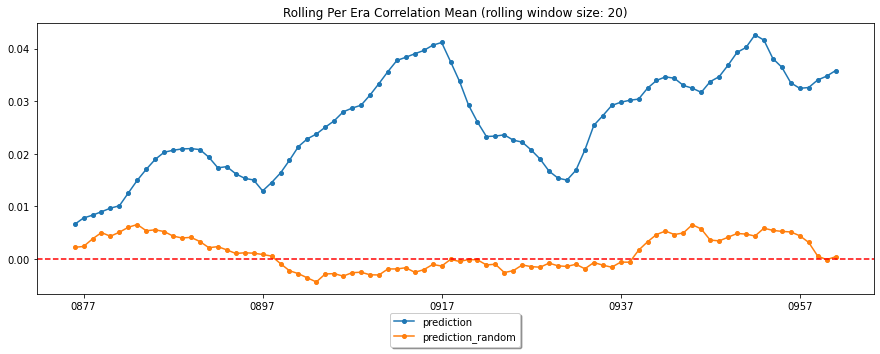

<module 'matplotlib.pyplot' from '/opt/anaconda3/envs/numerai-blocks37/lib/python3.7/site-packages/matplotlib/pyplot.py'>

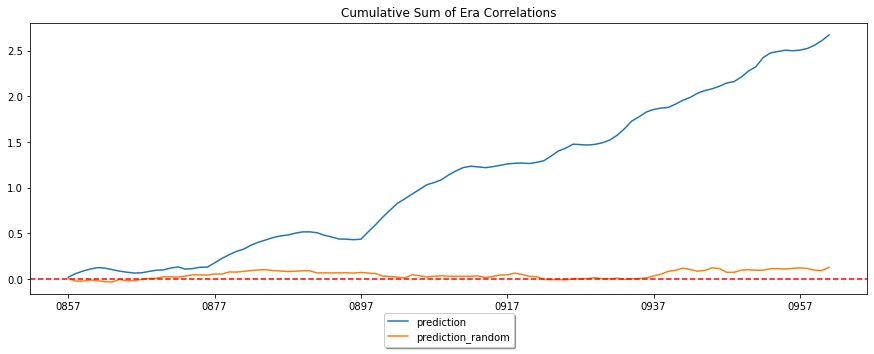

<IPython.core.display.Javascript object>

In [12]:
# other
evaluator.plot_correlations(
    test_dataf, pred_cols=["prediction", "prediction_random"], roll_mean=20
)

In [13]:
# Clean up environment
downloader.remove_base_directory()

⚠ Deleting directory for 'NumeraiClassicDownloader' ⚠
Path: '/Users/clepelaars/Desktop/crowdcent/repositories/numerai-blocks/nbs/eval_test_1234321'

<IPython.core.display.Javascript object>

--------------------------------------------------

In [14]:
# hide
# Run this cell to sync all changes with library
from nbdev.export import notebook2script

notebook2script()

Converted 00_misc.ipynb.
Converted 01_download.ipynb.
Converted 02_numerframe.ipynb.
Converted 03_preprocessing.ipynb.
Converted 04_model.ipynb.
Converted 05_postprocessing.ipynb.
Converted 06_modelpipeline.ipynb.
Converted 07_evaluation.ipynb.
Converted 08_key.ipynb.
Converted 09_submission.ipynb.
Converted 10_staking.ipynb.
Converted index.ipynb.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>